##  Compiling Braket circuits with the Qiskit-Braket provider

In this example notebook we show how we can use the [Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider/blob/main/docs/tutorials/0_tutorial_qiskit-braket-provider_overview.ipynb) `to_braket` function to provide circuit compilation for Braket circuits through the Qiskit compiler. Users can simply obtain a Circuit with the appropriate native gates, or explore advanced circuit compilation features, yielding programs ready for submission on Amazon Braket. 

> [!IMPORTANT]
> Further details and documentation for using the Qiskit-Braket provider can be found at the Qiskit-Braket provider [tutorials](https://github.com/qiskit-community/qiskit-braket-provider/tree/main/docs/tutorials) and [how-to](https://github.com/qiskit-community/qiskit-braket-provider/tree/main/docs/how_tos) pages. 


### Why circuit compilation? 

The success of a quantum circuit execution generally scales negatively with the number of gates and there infinite ways of expressing the same circuit. Given so many logically equivalent circuits, a simple way to improve our results is to choose representations that have less gates. 

There also are constraints given the physical device used. For instance, the connectivity of our device may differ from our input circuits, there is likely heterogeneity in the qubit quality, and we may have restrictions on the types of gates and parameters which can be utilized. Circuit compilation can help us create an executable circuit.

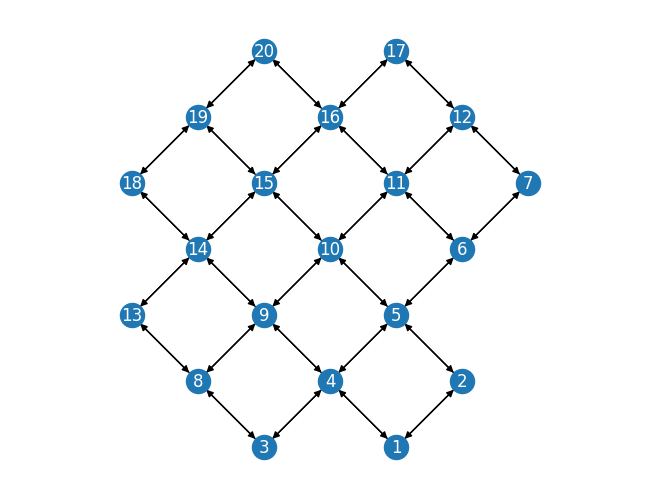

In [ ]:
from warnings import filterwarnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from circuit_utility import dprint
from matplotlib.colors import Normalize

from braket.aws import AwsDevice
from braket.devices import Devices

filterwarnings("ignore",category=UserWarning, module="qiskit_braket_provider")

garnet = AwsDevice(Devices.IQM.Garnet)

qubits = [
    [None,None,20,None,17,None,None],
    [None,19,None,16,None,12,None],
    [18,None,15,None,11,None,7,None],
    [None,14,None,10,None,6, None],
    [13,None,9,None,5,None],
    [None,8,None,4,None,2,None],
    [None,None,3,None,1,None,None]]

locs = {q:(j,-i) for i,row in enumerate(qubits) for j, q in enumerate(row) if q is not None}
nx.draw(garnet.topology_graph,locs, with_labels=True, font_color="white")
plt.axis('equal')
plt.show()

We can see a more detailed picture of physical attributes with some help from the device properties:

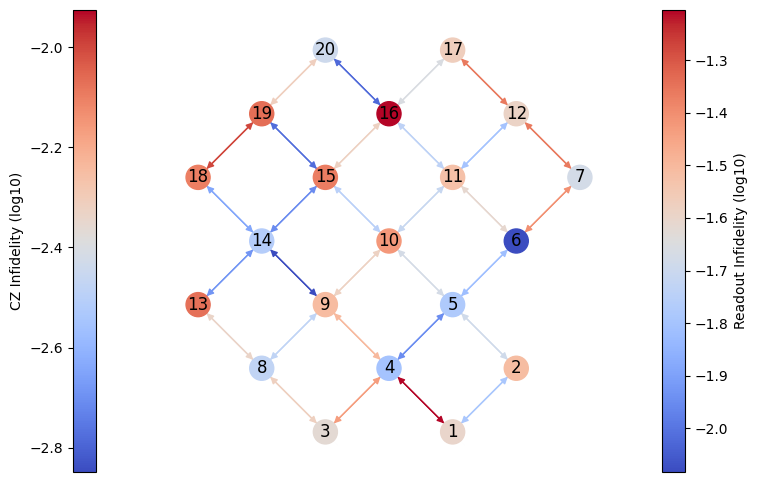

In [2]:

props = garnet.properties.provider.properties
graph_nodes, graph_edges =list(garnet.topology_graph.nodes()), list(garnet.topology_graph.edges())

node_vals = [1 - props['one_qubit'][str(node)]['fRO'] for node in graph_nodes]

edge_vals = []
for edge in graph_edges:
    if edge[0] > edge[1]:
        edge = (edge[1], edge[0])
    edge_key = f"{edge[0]}-{edge[1]}"
    edge_vals.append(1 - props['two_qubit'][edge_key]['fCZ'])

edge_vals = np.log10(edge_vals)
node_vals = np.log10(node_vals)

fig, ax = plt.subplots(figsize=(10,6))

nx.draw(garnet.topology_graph,
        locs,
        node_color=node_vals, 
        edge_color=edge_vals, 
        cmap=cm.coolwarm, 
        edge_cmap=cm.coolwarm, 
        with_labels=True,
        ax=ax)

node_norm = Normalize(vmin=min(node_vals), vmax=max(node_vals))
edge_norm = Normalize(vmin=min(edge_vals), vmax=max(edge_vals))
sm_nodes = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=node_norm)
sm_edges = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=edge_norm)

cbar1 = plt.colorbar(sm_nodes, ax=ax,label='Readout Infidelity (log10)')
cbar2 = plt.colorbar(sm_edges, ax=ax,label='CZ Infidelity (log10)',location='left',)
ax.set_aspect('equal')
plt.show()


In this visualization, we see how the CZ gate infidelity and qubit readout errors can differ by orders of magnitude. Other relevant metrics include $T_1$ and $T_2$ times and single-qubit gate infidelities. The success of a particular circuit choice can depend heavily on how the circuit is mapped to the underlying device. 

### Compilation via the Braket Service

As detailed in the [Developer Guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-compiled-circuits-inspecting.html), one way to get the compiled circuit, is to submit a job, and then return the circuit via the compiled program (which is also accessible on the console). Here we show this for an 8-qubit GHZ circuit:

> [!WARNING]
> Running this block will cost ~ $0.31, mainly the associate task submission cost for submitting to the Braket service plus a single per-shot price. 

> [!IMPORTANT]
> The following snippets will not work as-is with all providers. Rigetti results will be returned in Quil, and IonQ circuits are not returned. 

In [3]:
from braket.circuits import Circuit

ghz = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(2, 3).cnot(3, 4).cnot(4, 5).cnot(5, 6).cnot(6, 7)
dprint(ghz)

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │
      ┌───┐                                           
q0 : ─┤ H ├───●───────────────────────────────────────
      └───┘   │                                       
            ┌─┴─┐                                     
q1 : ───────┤ X ├───●─────────────────────────────────
            └───┘   │                                 
                  ┌─┴─┐                               
q2 : ─────────────┤ X ├───●───────────────────────────
                  └───┘   │                           
                        ┌─┴─┐                         
q3 : ───────────────────┤ X ├───●─────────────────────
                        └───┘   │                     
                              ┌─┴─┐                   
q4 : ─────────────────────────┤ X ├───●───────────────
                              └───┘   │               
                                    ┌─┴─┐             
q5 : ───────────────────────────────┤ X ├───●─────────
          

In [4]:
task = garnet.run(ghz, shots=1)
result = task.result()

In [5]:
compiled_circuit = Circuit().from_ir(result.get_compiled_circuit())
dprint(compiled_circuit)

T   : │        0        │         1         │  2  │         3         │  4  │         5         │  6  │ ||
                         ┌─────────────────┐                                                            ||
q4  : ───StartVerbatim───┤ PRx(1.57, 4.71) ├─────────────────────────────────────────────────────────── ||
               ║         └─────────────────┘                                                            ||
               ║         ┌─────────────────┐                                                            ||
q5  : ─────────║─────────┤ PRx(1.57, 4.71) ├─────────────────────────────────────────────────────────── ||
               ║         └─────────────────┘                                                            ||
               ║         ┌─────────────────┐                                                            ||
q6  : ─────────║─────────┤ PRx(1.57, 4.71) ├─────────────────────────────────────────────────────────── ||
               ║         └───────────

### Accessing Circuit Compilation via the Qiskit-Braket provider

Using the Qiskit-Braket provider, we can also utilize built-in features of Qiskit (namely the transpiler) to compile the circuit. The Qiskit-Braket provider provides pre-configured Backend objects, which populate relevant Qiskit Targets to perform noise-aware and device-aware transpilation. 

In [6]:
from qiskit_braket_provider import BraketAwsBackend, to_braket

backend = BraketAwsBackend(device=garnet)
ghz_garnet = to_braket(ghz, target=backend.target, optimization_level=3, qubit_labels=backend.qubit_labels)

dprint(ghz_garnet)

T   : │        0        │         1         │         2         │  3  │         4         │         5         │ ||
                         ┌─────────────────┐ ┌─────────────────┐                                                ||
q3  : ───StartVerbatim───┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├─────────────────────────────────────────────── ||
               ║         └─────────────────┘ └─────────────────┘                                                ||
               ║         ┌─────────────────┐ ┌─────────────────┐                                                ||
q4  : ─────────║─────────┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├─────────────────────────────────────────────── ||
               ║         └─────────────────┘ └─────────────────┘                                                ||
               ║         ┌─────────────────┐ ┌─────────────────┐                                                ||
q5  : ─────────║─────────┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├────────────────

Importantly, we see that with Braket-compiled and Qiskit-compiled circuits, a different qubit layout has been applied, based on knowledge of the device. 

If instead, we want to perform more granular manipulation, we can directly specify items like `basis_gates`, `connectivity`, `angle_restrictions`, the `optimization_level` of the preset_pass_manager, as well `qubit_labels` that we map the Braket circuit back to. For those more familiar with Qiskit, we can also supply a custom PassManager object. 

> [!IMPORTANT]
> Verbatim flags will not always be applied to a circuit. These are mainly supplied when a device or Target is specified, the verbatim flag is specified, or when a custom PassManger is utilized. To remove measurement, use the `to_qiskit` feature with `add_measurement=False`. 

> [!NOTE]
> Circuit indexing can also be accomplished via the `target_mapping` keyword in `Circuit().add_circuit`. However, for consistency with the contiguous Qiskit ordering convention, using  `target.qubit_labels` is preferred. 

In [7]:
ghz_basis = to_braket(ghz, basis_gates=["cz","r"]) #  
print("Circuit in a native basis for IQM:")
dprint(ghz_basis) # 

print("Circuit across a linear layout:")
ghz_linear = to_braket(ghz, connectivity = [[5,4],[4,3],[3,2],[2,0],[0,6],[6,1],[1,7]], optimization_level=2) # custom linear layout
dprint(ghz_linear)


Circuit in a native basis for IQM:
T  : │         0         │         1         │  2  │         3         │         4         │  5  │ ||
      ┌─────────────────┐ ┌─────────────────┐                                                      ||
q0 : ─┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├───●───────────────────────────────────────────────── ||
      └─────────────────┘ └─────────────────┘   │                                                  ||
      ┌─────────────────┐ ┌─────────────────┐ ┌─┴─┐ ┌─────────────────┐ ┌─────────────────┐        ||
q1 : ─┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├─┤ Z ├─┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├───●─── ||
      └─────────────────┘ └─────────────────┘ └───┘ └─────────────────┘ └─────────────────┘   │    ||
      ┌─────────────────┐ ┌─────────────────┐                                               ┌─┴─┐  ||
q2 : ─┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├───────────────────────────────────────────────┤ Z ├─ ||
      └─────────────────┘ └─────────────────┘  

The `optimization_level` matches the [Qiskit transpiler keyword](https://quantum.cloud.ibm.com/docs/en/guides/set-optimization). The Qiskit transpiler (which performs quantum circuit compilation, also called transpilation) can take numerous constraints reflecting information on a device, including but not limited to, the unitary gate set, device connectivity, gate error rates and timing, and more. This can be supplied via a backend or Target, or as additional arguments. The optimization levels correspond with hierarchically increasing levels of optimization, which will first ensure that the circuit can be run on a particular basis set and connectivity, and with higher levels can perform advanced rerouting and attempt to simplify unitary gate sequences. 

In [8]:

ghz_4 = Circuit().cnot(0,2).cnot(0,1).cnot(2,3)

for opt_level in [0,1,2,3]:
    print(f"Optimization Level: {opt_level}")
    circ =to_braket(ghz_4, optimization_level=opt_level, target=backend.target, qubit_labels=backend.qubit_labels)
    n_cz = [ins.operator.name for ins in circ.instructions].count("CZ")
    print(f"Number of CZ Gates: {n_cz}")
    dprint(circ)


Optimization Level: 0
Number of CZ Gates: 6
T  : │        0        │         1         │         2         │         3         │  4  │         5         │ ||
                                                                                                               ||
q1 : ───StartVerbatim───────────────────────────────────────────────────────────────────────────────────────── ||
              ║                                                                                                ||
              ║         ┌─────────────────┐ ┌─────────────────┐                                                ||
q2 : ─────────║─────────┤ PRx(1.57, 1.57) ├─┤ PRx(3.14, 0.00) ├─────────────────────────────────────────────── ||
              ║         └─────────────────┘ └─────────────────┘                                                ||
              ║         ┌─────────────────┐        ┌───┐        ┌─────────────────┐ ┌───┐ ┌─────────────────┐  ||
q3 : ─────────║─────────┤ PRx(1.57, 0.00) ├─

For this example, the main difference is between Qiskit's optimization levels 0 and 1, though for more complex (and particularly larger) circuits, additional resynthesis and more agressive rerouting might be beneficial.

### Further Information

The `to_braket` function supports Qiskit QuantumCircuits, as well as functional OpenQASM3 programs. More information and examples can be seen in the related [tutorial](https://qiskit-community.github.io/qiskit-braket-provider/tutorials/5_tutorial_transpilation.html#Transpiling-OpenQASM-3). Quantum circuit compilation is a rich and critical field, relevant for current devices as well as fault tolerant considerations. 